In [1]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 37.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install allennlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.2/594.2 kB 11.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from rdkit import Chem
import torch
from allennlp.modules.feedforward import FeedForward
from allennlp.modules.seq2seq_encoders import (LstmSeq2SeqEncoder)
from torch import nn
from torch.distributions import Categorical
import numpy as np
import torch.nn.functional as F
from rdkit import Chem, RDLogger
from torch import nn
from torch.nn.utils import clip_grad_value_
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
from PIL import Image
import csv

2024-05-02 07:58:10.815763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 07:58:10.815875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 07:58:10.941270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# the code for the model was taken from repository: https://github.com/urchade/molgen
class Generator(nn.Module):

    def __init__(self, latent_dim, vocab_size, start_token, end_token):
        """Generator

        Args:
            latent_dim (int): [description]
            vocab_size (int): vocab size without padding
            start_token ([int]): start token (without padding idx)
            end_token ([int]): end token (without padding idx)
        """

        super().__init__()
        self.vocab_size = vocab_size
        self.start_token = start_token
        self.end_token = end_token
        self.embedding_layer = nn.Embedding(self.vocab_size, latent_dim)
        self.project = FeedForward(
            input_dim=latent_dim,
            num_layers=2,
            hidden_dims=[latent_dim * 2, latent_dim * 2],
            activations=[nn.ReLU(), nn.ELU(alpha=0.1)],
            dropout=[0.1, 0.1]
        )
        self.rnn = nn.LSTMCell(latent_dim, latent_dim)
        self.output_layer = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(latent_dim * 2, vocab_size - 1)
        )

    def forward(self, z, max_len=20):
        """[summary]

        Args:
            z (torch.Tensor): [description]
            max_len (int, optional): [description]. Defaults to 20.

        Returns:
            dict: x [B, max_len], log_probabilities [B, max_len, vocab], entropies [B,]
        """

        batch_size = z.shape[0]
        starts = torch.full(
            size=(batch_size,), fill_value=self.start_token, device=z.device).long()
        emb = self.embedding_layer(starts)
        x = []
        log_probabilities = []
        entropies = []
        h, c = self.project(z).chunk(2, dim=1)
        for i in range(max_len):
            h, c = self.rnn(emb, (h, c))
            logits = self.output_layer(h)
            dist = Categorical(logits=logits)
            sample = dist.sample()
            x.append(sample)
            log_probabilities.append(dist.log_prob(sample))
            entropies.append(dist.entropy())
            emb = self.embedding_layer(sample)
        x = torch.stack(x, dim=1)
        log_probabilities = torch.stack(log_probabilities, dim=1)
        entropies = torch.stack(entropies, dim=1)
        end_pos = (x == self.end_token).float().argmax(dim=1).cpu()
        seq_lengths = end_pos + 1
        seq_lengths.masked_fill_(seq_lengths == 1, max_len)
        _x = []
        _log_probabilities = []
        _entropies = []
        for x_i, logp, ent, length in zip(x, log_probabilities, entropies, seq_lengths):
            _x.append(x_i[:length])
            _log_probabilities.append(logp[:length])
            _entropies.append(ent[:length].mean())
        x = torch.nn.utils.rnn.pad_sequence(
            _x, batch_first=True, padding_value=-1)
        x = x + 1 
        return {'x': x, 'log_probabilities': _log_probabilities, 'entropies': _entropies}


class RecurrentDiscriminator(nn.Module):

    def __init__(self, hidden_size, vocab_size, start_token, bidirectional=True):
        """Reccurent discriminator

        Args:
            hidden_size (int): model hidden size
            vocab_size (int): vocabulary size
            bidirectional (bool, optional): [description]. Defaults to True.
        """

        super().__init__()
        self.start_token = start_token
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.rnn = LstmSeq2SeqEncoder(
            hidden_size, hidden_size, num_layers=1, bidirectional=bidirectional)
        if bidirectional:
            hidden_size = hidden_size * 2
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """[summary]

        Args:
            x ([type]): [description]

        Returns:
            [type]: [description]
        """

        batch_size, _ = x.size()
        starts = torch.full(
            size=(batch_size, 1), fill_value=self.start_token, device=x.device).long()
        x = torch.cat([starts, x], dim=1)
        mask = x > 0
        emb = self.embedding(x)
        x = self.rnn(emb, mask)
        out = self.fc(x).squeeze(-1)  
        return {'out': out[:, 1:], 'mask': mask.float()[:, 1:]}

In [5]:
class Tokenizer(object):

    def __init__(self, data):
        unique_char = list(set(''.join(data))) + ['<eos>'] + ['<sos>']
        self.mapping = {'<pad>': 0}
        for i, c in enumerate(unique_char, start=1):
            self.mapping[c] = i
        self.inv_mapping = {v: k for k, v in self.mapping.items()}
        self.start_token = self.mapping['<sos>']
        self.end_token = self.mapping['<eos>']
        self.vocab_size = len(self.mapping.keys())

    def encode_smile(self, mol, add_eos=True):
        out = [self.mapping[i] for i in mol]
        if add_eos:
            out = out + [self.end_token]
        return torch.LongTensor(out)

    def batch_tokenize(self, batch):
        out = map(lambda x: self.encode_smile(x), batch)
        return torch.nn.utils.rnn.pad_sequence(list(out), batch_first=True)

In [6]:
RDLogger.DisableLog('rdApp.*')

class MolGen(nn.Module):

    def __init__(self, data, hidden_dim=128, lr=1e-3, device='cpu'):
        """[summary]

        Args:
            data (list[str]): [description]
            hidden_dim (int, optional): [description]. Defaults to 128.
            lr ([type], optional): learning rate. Defaults to 1e-3.
            device (str, optional): 'cuda' or 'cpu'. Defaults to 'cpu'.
        """
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.tokenizer = Tokenizer(data)
        self.generator = Generator(
            latent_dim=hidden_dim,
            vocab_size=self.tokenizer.vocab_size - 1,
            start_token=self.tokenizer.start_token - 1, 
            end_token=self.tokenizer.end_token - 1,
        ).to(device)
        
        self.discriminator = RecurrentDiscriminator(
            hidden_size=hidden_dim,
            vocab_size=self.tokenizer.vocab_size,
            start_token=self.tokenizer.start_token,
            bidirectional=True
        ).to(device)
        self.generator_optim = torch.optim.Adam(
            self.generator.parameters(), lr=lr)
        self.discriminator_optim = torch.optim.Adam(
            self.discriminator.parameters(), lr=lr)
        self.b = 0.  

    def sample_latent(self, batch_size):
        """Sample from latent space

        Args:
            batch_size (int): number of samples

        Returns:
            torch.Tensor: [batch_size, self.hidden_dim]
        """
        return torch.randn(batch_size, self.hidden_dim).to(self.device)

    def discriminator_loss(self, x, y):
        """Discriminator loss

        Args:
            x (torch.LongTensor): input sequence [batch_size, max_len]
            y (torch.LongTensor): sequence label (zeros from generatoe, ones from real data)
                                  [batch_size, max_len]

        Returns:
            loss value
        """
        y_pred, mask = self.discriminator(x).values()
        loss = F.binary_cross_entropy(
            y_pred, y, reduction='none') * mask
        loss = loss.sum() / mask.sum()
        return loss

    def train_step(self, x):
        """One training step

        Args:
            x (torch.LongTensor): sample form real distribution
        """

        batch_size, len_real = x.size()
        x_real = x.to(self.device)
        y_real = torch.ones(batch_size, len_real).to(self.device)
        z = self.sample_latent(batch_size)
        generator_outputs = self.generator.forward(z, max_len=20)
        x_gen, log_probs, entropies = generator_outputs.values()
        _, len_gen = x_gen.size()
        y_gen = torch.zeros(batch_size, len_gen).to(self.device)

        #######################
        # Train Discriminator #
        #######################

        self.discriminator_optim.zero_grad()
        fake_loss = self.discriminator_loss(x_gen, y_gen)
        real_loss = self.discriminator_loss(x_real, y_real)
        discr_loss = 0.5 * (real_loss + fake_loss)
        discr_loss.backward()
        clip_grad_value_(self.discriminator.parameters(), 0.1)
        self.discriminator_optim.step()

        ###################
        # Train Generator #
        ###################

        self.generator_optim.zero_grad()
        y_pred, y_pred_mask = self.discriminator(x_gen).values()
        R = (2 * y_pred - 1)
        lengths = y_pred_mask.sum(1).long()
        list_rewards = [rw[:ln] for rw, ln in zip(R, lengths)]
        generator_loss = []
        for reward, log_p in zip(list_rewards, log_probs):
            reward_baseline = reward - self.b
            generator_loss.append((- reward_baseline * log_p).sum())

        generator_loss = torch.stack(generator_loss).mean() - \
            sum(entropies) * 0.01 / batch_size
        with torch.no_grad():
            mean_reward = (R * y_pred_mask).sum() / y_pred_mask.sum()
            self.b = 0.9 * self.b + (1 - 0.9) * mean_reward
        generator_loss.backward()
        clip_grad_value_(self.generator.parameters(), 0.1)
        self.generator_optim.step()
        return {'loss_disc': discr_loss.item(), 'mean_reward': mean_reward}

    def create_dataloader(self, data, batch_size=128, shuffle=True, num_workers=5):
        """create a dataloader

        Args:
            data (list[str]): list of molecule smiles
            batch_size (int, optional): Defaults to 128.
            shuffle (bool, optional): Defaults to True.
            num_workers (int, optional): Defaults to 5.

        Returns:
            torch.data.DataLoader: a torch dataloader
        """

        return DataLoader(
            data,
            batch_size=batch_size,
            shuffle=shuffle,
            collate_fn=self.tokenizer.batch_tokenize,
            num_workers=num_workers
        )

    def train_n_steps(self, train_loader, max_step=10000, evaluate_every=50):
        """Train for max_step steps

        Args:
            train_loader (torch.data.DataLoader): dataloader
            max_step (int, optional): Defaults to 10000.
            evaluate_every (int, optional): Defaults to 50.
        """

        iter_loader = iter(train_loader)
        for step in range(max_step):
            try:
                batch = next(iter_loader)
            except:
                iter_loader = iter(train_loader)
                batch = next(iter_loader)
            self.train_step(batch)
            if step % evaluate_every == 0:
                self.eval()
                score = self.evaluate_n(100)
                self.train()
                print(f'valid = {score: .2f}')

    def get_mapped(self, seq):
        """Transform a sequence of ids to string

        Args:
            seq (list[int]): sequence of ids

        Returns:
            str: string output
        """
        return ''.join([self.tokenizer.inv_mapping[i] for i in seq])

    @torch.no_grad()
    def generate_n(self, n):
        """Generate n molecules

        Args:
            n (int)

        Returns:
            list[str]: generated molecules
        """
        z = torch.randn((n, self.hidden_dim)).to(self.device)
        x = self.generator(z)['x'].cpu()
        lenghts = (x > 0).sum(1)
        return [self.get_mapped(x[:l-1].numpy()) for x, l in zip(x, lenghts)]

    def evaluate_n(self, n):
        """Evaluation: frequence of valid molecules using rdkit

        Args:
            n (int): number of sample

        Returns:
            float: requence of valid molecules
        """
        pack = self.generate_n(n)
        print(pack[:2])
        valid = np.array([Chem.MolFromSmiles(k) is not None for k in pack])
        return valid.mean()

In [7]:
data = []
with open('/kaggle/input/prep2-data/prep2.csv', "r") as f:
    next(f)
    for line in f:
        columns = line.split(",")
        chromophore = columns[1].strip() 
        data.append(chromophore)
        
random.shuffle(data)
print(data[:10])

['CCCCN(CCCC)c1ccc2c(-c3cccc(CN4CCOCC4)c3)c3ccc(=[NH2+])cc-3oc2c1', '[O-]c1c(-c2ccccc2)cc(-[n+]2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)cc1-c1ccccc1', 'C(=C/c1ccncn1)\\c1ccc(-c2ccc(N(c3ccccc3)c3ccccc3)cc2)cc1', 'F[B-]1(F)n2c(c3cccc4cccc2c43)=Nc2cccc[n+]21', 'O=[N+]([O-])c1ccc(NCCNCc2c3ccccc3cc3ccccc23)c([N+](=O)[O-])c1', 'c1ccc(-n2c3ccccc3c3cc(-c4ccn5nc(-c6ccc(-n7c8ccccc8c8ccccc87)cc6)nc5c4)ccc32)cc1', 'CC(C)(C)c1cccc2c1oc1nc3oc4ccc(-n5c6ccccc6c6ccccc65)cc4c3cc12', 'CN1c2cc3nc4cc(Br)c(Br)cc4nc3cc2N(C)C1(C)C', 'c1ccc(B2Nc3cc4c(cc3-c3sccc32)NB(c2ccccc2)c2ccsc2-4)cc1', 'Cc1nc(-c2ccc(N3c4ccccc4C(c4ccccc4)(c4ccccc4)c4ccccc43)cc2)cc(-c2ccc(N3c4ccccc4C(c4ccccc4)(c4ccccc4)c4ccccc43)cc2)n1']


In [10]:
gan_mol = MolGen(data, hidden_dim=256, lr=1e-4, device="cuda")
loader = gan_mol.create_dataloader(data, batch_size=128, shuffle=True, num_workers=4)

vocab size 48


In [11]:
gan_mol.train_n_steps(loader, max_step=70000, evaluate_every=2000)

['/\\H', '9o']
valid =  0.00
['1=PNH4+nn7c@G]', '5Be1Sr-Ocs6(+5-9(0c']
valid =  0.02
['sLF', 'sLle4lNC-n=]C4ioIlI']
valid =  0.00
['[6=)-3O(O.SclB#/7I)', 'B7cs4.L)I-c@eHCC3l']
valid =  0.02
['+]eT#r5S3(n.%)o1To)', 'BO394C%22)l.TcHbr@']
valid =  0.03
['II', '1']
valid =  0.06
['c', '4943L+6(a73s77(NrLF']
valid =  0.02
['6\\+][4NaN.GC]/5r-/s', 'n)(NnGT=()n1r51c]Ol']
valid =  0.02
['=i=-[T\\+S=[%', 'HTSc0+.5P4-FbST3/3i']
valid =  0.04
['n[@93To', 'H#899ro+r5S08oB+[+2']
valid =  0.04
['P7G@', 'Sc#L-NCNcG)@boI3=oI']
valid =  0.11
['p3Ol18]S1T', '\\[@bnPTrn#s7lPa3+sP']
valid =  0.05
['(', 'CC(=0)Oo05FNTO\\4']
valid =  0.09
['9i%L5N]\\)5=2i/NbsP=', 'I%-)N(H9pTL05%p=90H']
valid =  0.04
['O8oGcG)(sLI4/L6sOr/', 'NIL4nP.IrGNnNB9SS-O']
valid =  0.08
['H#T-oS4ocbs#\\8aFro3', '1Cpo']
valid =  0.03
['blrb+H=Hp[Ts8nIT750', 'sF\\Cnrob]p0']
valid =  0.10
['pO[cPllPb', 'lB7@P#9S))2CN=PC+eC']
valid =  0.01
['P51p]s1oa', 'I\\P@oH.(obL)SnLS[Gi']
valid =  0.00
['Nc#/n%3.9O4[SHo04)H', 'OC.#FIci-ie(=[s.l0n']
v

35


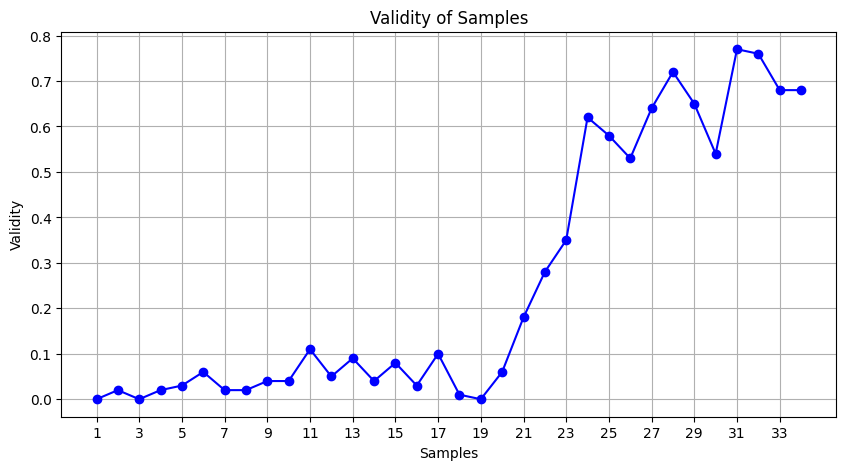

In [3]:
# the validity scores from the training were collected and plotted
validities = [0.00, 0.02, 0.00, 0.02, 0.03, 0.06, 0.02, 0.02, 0.04, 0.04, 0.11, 0.05, 0.09, 0.04, 0.08, 0.03, 0.10, 0.01, 0.00, 0.06, 0.18, 0.28, 0.35, 0.62, 0.58, 0.53, 0.64, 0.72, 0.65, 0.54, 0.77, 0.76, 0.68, 0.68]
x = range(1, len(validities) + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, validities, marker='o', color='b', linestyle='-')
plt.xlabel('Samples')
plt.ylabel('Validity')
plt.title('Validity of Samples')
plt.grid(True)
plt.xticks(range(1, len(validities) + 1, 2))
plt.show()


In [12]:
torch.save(gan_mol.state_dict(), 'molgen.pth')

/opt/conda/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


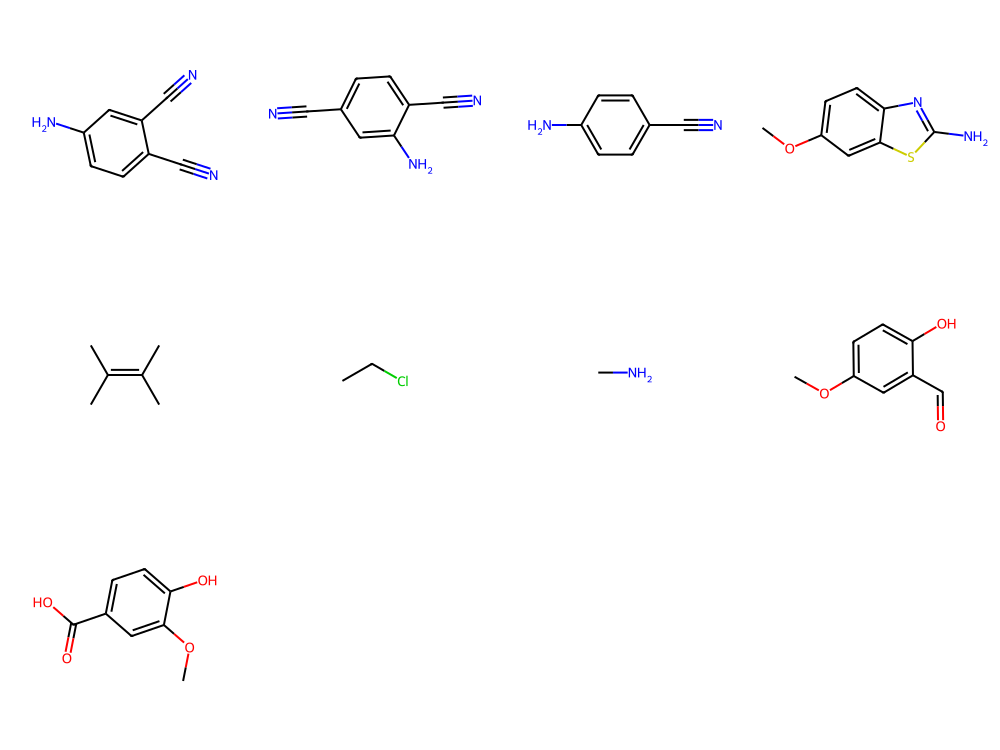

In [13]:
smiles_list = gan_mol.generate_n(10000)
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

image_path = '/kaggle/working/mol_drawing.png'
img = Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)

Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)

In [14]:
print(len(smiles_list))
print(len(mol_list))

num_valid_molecules = len([mol for mol in mol_list if mol is not None])
print("Number of valid molecules:", num_valid_molecules)
valid_mol = []
for i, mol in enumerate(mol_list):
    if mol != None:
        valid_mol.append(smiles_list[i])
print('valid molecules', valid_mol)

10000
10000
Number of valid molecules: 7627
valid molecules ['N#Cc1ccc(N)cc1C#N', 'N#Cc1ccc(C#N)c(N)c1', 'N#Cc1ccc(N)cc1', 'COc1ccc2nc(N)sc2c1', 'CC(C)=C(C)C', 'CCCl', 'CN', 'COc1ccc(O)c(C=O)c1', 'COc1cc(C(=O)O)ccc1O', 'N#Cc1ccc(C#N)c(N)c1', 'Nc1ccncc1', 'COc1ncccc1B(O)O', 'C/C=C/c1cc(OC)ccc1O', 'O=Cc1cc(O)ccc1O', 'N#Cc1coc2ccccc2c1=O', 'Oc1ccc2ccccc2c1', 'N#Cc1coc2ccccc2c1=O', 'COc1ccc(OC)c(C=O)c1', 'N#Cc1coc2ccccc2c1=O', 'N#Cc1ccc(C#N)c(N)c1', 'O=Cc1cc(O)ccc1O', 'COc1cc(C(=O)O)ccc1O', 'N#Cc1coc2ccccc2c1=O', 'Cc1cc(C)nc(N)n1', 'N#Cc1cc(N)cc(C#N)c1', 'COc1ccc(O)c(C=O)c1', 'II', 'N#Cc1cc(N)cc(C#N)c1', 'COc1cc(C(=O)O)ccc1O', 'CN(C)c1ccc(C#N)cc1', 'Nc1cccnc1', 'N#Cc1coc2ccccc2c1=O', 'N#Cc1coc2ccccc2c1=O', 'COc1ccc(OC)c(C=O)c1', 'C=Cc1ccc(OC)cc1', 'COc1ncccc1B(O)O', 'N#Cc1cc(N)cc(C#N)c1', 'N#Cc1coc2ccccc2c1=O', 'N#Cc1ccc(N)cc1', 'COc1ccc(OC)c(C=O)c1', 'CC(=O)Nc1ccc(O)cc1', 'N#Cc1ccc(C#N)c(N)c1', 'N#Cc1ccc(C#N)c(N)c1', 'COc1cc(C(=O)O)ccc1O', 'COc1ccc(O)cc1C=O', 'Cc1cc(C)nc(C)c1', 'S#Cc1cccc

In [15]:
smiles_file_path = '/kaggle/working/smiles_list.txt'
with open(smiles_file_path, 'w') as file:
    for smiles in smiles_list:
        file.write(smiles + '\n')
        
smiles_file_path = '/kaggle/working/mol_list.txt'
with open(smiles_file_path, 'w') as file:
    for mol in mol_list:
        if mol is not None:
            smiles = Chem.MolToSmiles(mol)
            if smiles:
                file.write(smiles + '\n')

In [19]:
print(mol_list)

[<rdkit.Chem.rdchem.Mol object at 0x7ea1e17d3920>, <rdkit.Chem.rdchem.Mol object at 0x7ea1e17d3840>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548b30>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1549070>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1549000>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548e40>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548eb0>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548890>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548270>, None, <rdkit.Chem.rdchem.Mol object at 0x7ea1d15484a0>, None, None, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548970>, None, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548cf0>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548c10>, None, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548820>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548430>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548120>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d15489e0>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d15482e0>, <rdkit.Chem.rdchem.Mol object at 0x7ea1d1548d60>, <rdkit.Chem.rdchem.

In [21]:
smiles_file_path = '/kaggle/working/mol_list_molgen.csv'
header = ['Index', 'SMILES']

with open(smiles_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for idx, mol in enumerate(valid_mol, start=1):
        if mol is not None:
            writer.writerow([idx, mol])
